Simulation scenario #5 (Index 6.1 from the simulation_scenarios document)

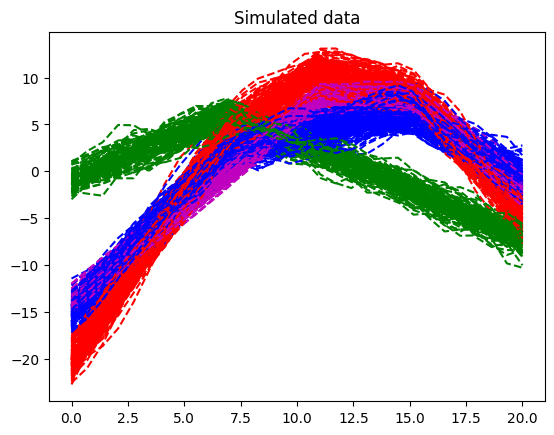

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

# Ignore convergence warnings
import warnings
warnings.filterwarnings("ignore")

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.8 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sample from the Gaussian process distribution
nb_of_samples = 30  # Number of points in each function
# Independent variable samples
t = np.expand_dims(np.linspace(0, 20, nb_of_samples), 1)
Σ = exponentiated_quadratic(t/0.5, t/12)  # Kernel of data points
Σ2 = exponentiated_quadratic(t, t/12)  # Kernel of data points
Σ3 = exponentiated_quadratic(t, t*2/3)  # Kernel of data points


# Declare the mean curve
mean_curve = np.zeros((3, len(t)))
# Mean curve with white noise
mean_curve[0] = np.reshape(6 - np.abs(t - 11), (nb_of_samples))
mean_curve[1] = np.reshape(6 - np.abs(t - 7), (nb_of_samples))
mean_curve[2] = np.reshape(6 - np.abs(t - 15), (nb_of_samples))


mixture_k = [0.3, 0.3, 0.2, 0.2]
n = 500
Y = np.zeros((n, len(t)))
simulation_label = np.zeros(n)

for i in range(n):
    # generate a random number between 0 and 1
    r = np.random.rand()
    # find the index of the mixture component
    if r < mixture_k[0]:
        # draw for the first component
        ys = -5 + np.reshape(t/2, (nb_of_samples)) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ2, size=1) + np.random.multivariate_normal(mean=mean_curve[1], cov=Σ3, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='b')
        # Remember the label of the component
        simulation_label[i] = 0
    elif r < mixture_k[0] + mixture_k[1]:
        # draw for the first component
        ys = -5 + np.reshape(t/2, (nb_of_samples)) + np.random.multivariate_normal(mean=mean_curve[0], cov=Σ, size=1) + np.random.multivariate_normal(mean=mean_curve[1], cov=Σ2, size=1) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ3, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.5)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='r')
        # Remember the label of the component
        simulation_label[i] = 1
    elif r < mixture_k[0] + mixture_k[1] + mixture_k[2]:
        # draw for the first component
        ys = np.random.multivariate_normal(mean=mean_curve[1], cov=Σ3, size=1)+ np.random.normal(0, 0.08, len(t))*np.sqrt(10)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='g')
        # Remember the label of the component
        simulation_label[i] = 2
    else:
        # draw for the first component
        ys = np.random.multivariate_normal(mean=mean_curve[0], cov=Σ, size=1) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.5)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='m')
        # Remember the label of the component
        simulation_label[i] = 3

plt.title('Simulated data')
plt.show()

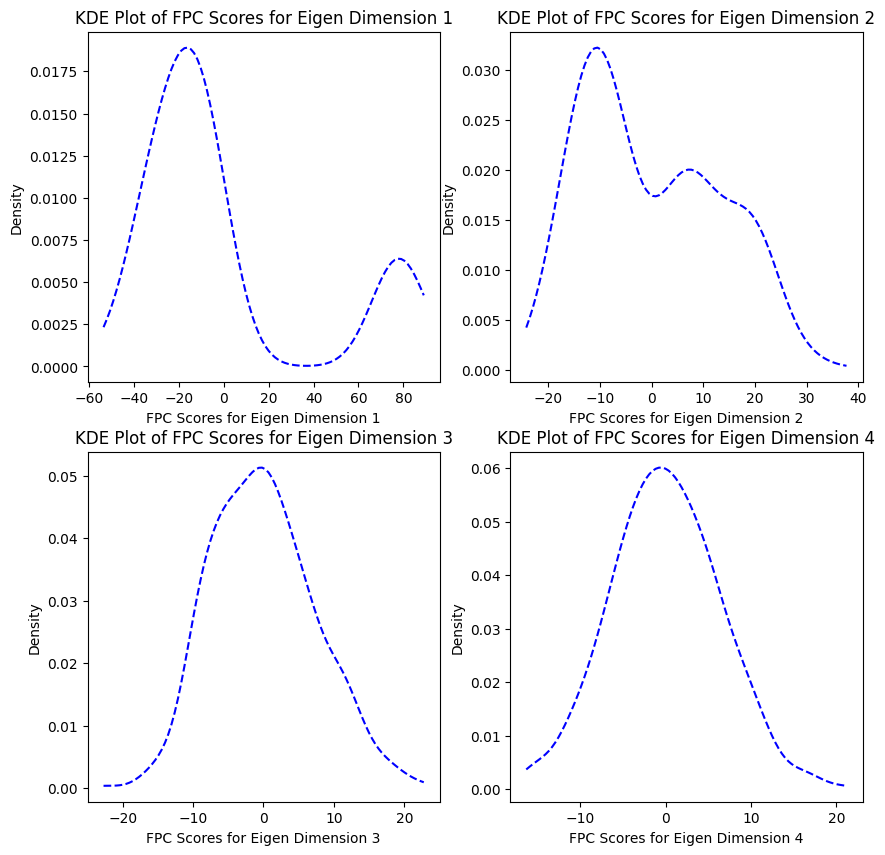

In [7]:
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, 10, 150)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [0.83313616 0.09416892 0.02837288 0.02156725 0.00568248 0.00485356
 0.00427657 0.00365726 0.0026507  0.00163421]


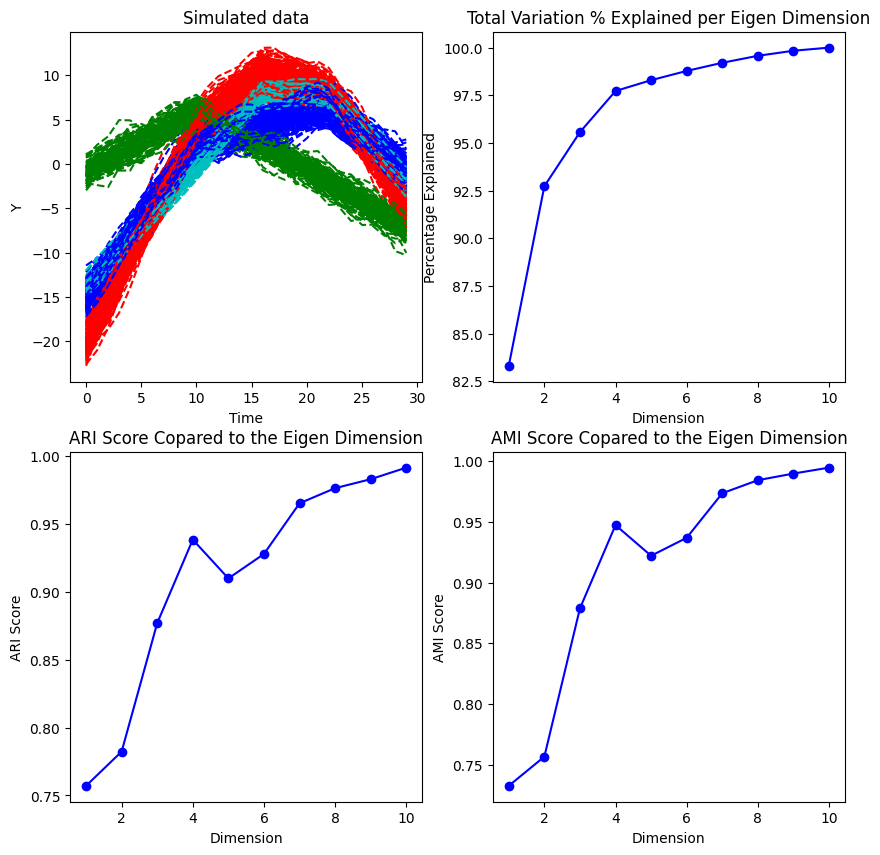

In [8]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, Y, 150, simulation_label, 4)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, simulation_label, Y)

Percentage of variation explained by each eigen dimensions:  [0.84089773 0.09072721 0.02751155 0.01975885 0.00546048 0.00454892
 0.00425345 0.00282506 0.00216886 0.00184789]


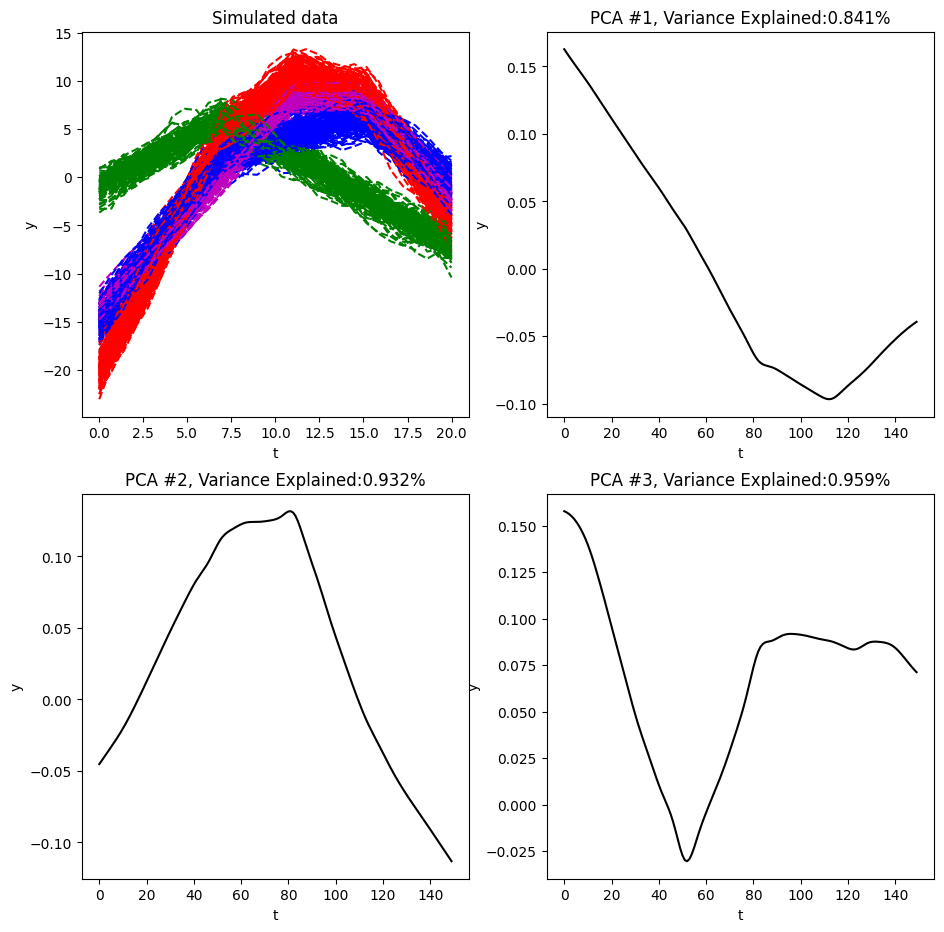

In [4]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, Y, 150, simulation_label, 4)

new_t = np.arange(0, 150, 1)

# Plot the data as the first 3 eigenfunctions of the data on four separate plots, in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(11, 11))
# Plot the simulated data
for i in range(len(Y)):
    if simulation_label[i] == 0:
        axs[0, 0].plot(t, Y[i], linestyle='--', color='b')
    elif simulation_label[i] == 1:
        axs[0, 0].plot(t, Y[i], linestyle='--', color='r')
    elif simulation_label[i] == 2:
        axs[0, 0].plot(t, Y[i], linestyle='--', color='g')
    else:
        axs[0, 0].plot(t, Y[i], linestyle='--', color='m')
axs[0, 0].set_title('Simulated data')
axs[0, 0].set_xlabel('t')
axs[0, 0].set_ylabel('y')
axs[0, 1].plot(new_t, eigen_functions[0], color='k')
axs[0, 1].set_title('PCA #1, Variance Explained:' + str(round(variance[0], 3)) + '%')
axs[0, 1].set_xlabel('t')
axs[0, 1].set_ylabel('y')
axs[1, 0].plot(new_t, eigen_functions[1], color='k')
axs[1, 0].set_title('PCA #2, Variance Explained:' + str(round(variance[0] + variance[1], 3)) + '%')
axs[1, 0].set_xlabel('t')
axs[1, 0].set_ylabel('y')
axs[1, 1].plot(new_t, eigen_functions[2], color='k')
axs[1, 1].set_title('PCA #3, Variance Explained:' + str(round(variance[0] + variance[1] + variance[2], 3)) + '%')
axs[1, 1].set_xlabel('t')
axs[1, 1].set_ylabel('y')
plt.show()

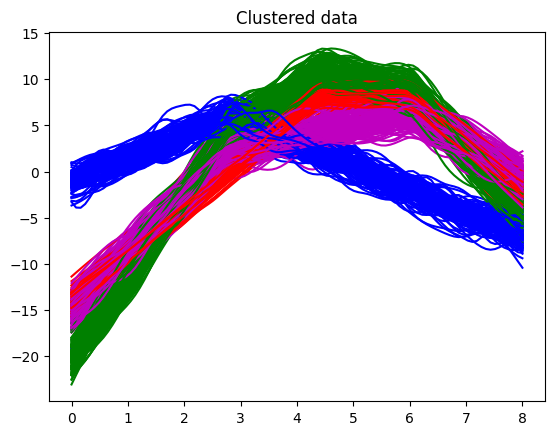

AMI score:
0.9568950382381599
ARM score:
0.9695506441172033


In [5]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, 9, 100)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 4)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

# Get the AMI score
print("AMI score:")
print(adjusted_mutual_info_score(simulation_label, labels))

# Get the ARM scoree
print("ARI score:")
print(adjusted_rand_score(simulation_label, labels))

FCUBT Method Test

In [11]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(Y[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

data = DenseFunctionalData(t, Y)
# Build the tree
root_node = Node(data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score: %f" % adjusted_rand_score(simulation_label, fcubt.labels_join))
# Get the AMI
print("AMI score: %f" % adjusted_mutual_info_score(simulation_label, fcubt.labels_join))


ARI score: 1.000000
AMI score: 1.000000


In [29]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', Y, delimiter=',')
np.savetxt('Data/LabelStore.csv', simulation_label, delimiter=',')

# Next run the the R scripts

In [30]:
# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)

print("ARI score for funHDDC: %f" % adjusted_rand_score(simulation_label, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(simulation_label, predicted_labels))

ARI score for funHDDC: 0.218226
AMI score for funHDDC: 0.470156


In [31]:
# To simulate funFEM, run run the R file funFEM.R

# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 5))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(simulation_label, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(simulation_label, labels))

ARI score for funFEM: 0.737096
AMI score for funFEM: 0.818835
